# The Variational Quantum Linear Solver

#### Editor's note:

Consulted Pennylane tutorial on VQLS, found [here](https://pennylane.ai/qml/demos/tutorial_vqls).

Qiskit version: `1.4.1`

## 1. Introduction

The Variational Quantum Linear Solver (VQLS) is a kind of variational quantum algorithm (VQA) that solves systems of linear equations. 

Given a matrix $A$, such that $A |x\rangle \ = \ |b\rangle$, where $|b\rangle$ is some known vector, the VQLS algorithm finds a normalized $|x\rangle$ that is proportional to $|x\rangle$, which makes the above equation true.



## 2. The Algorithm

We start off with a qubit register, with each qubit initialized to $|0\rangle$. 

First, we prepare a candidate solution, $|x(\alpha)\rangle$ conditioned on a set of parameters $\alpha$. This is done using an ansatz $V(\alpha)$, where $|x(\alpha)\rangle = V(\alpha) |0\rangle$. Next, prepare $|b\rangle = U|0\rangle$ for some unitary $U$.

Second, we design a quantum circuit to compute a cost, $C(\alpha)$, that captures the idea of the difference between $| x(\alpha) \rangle$ and the real solution, $|x_0\rangle$, to $A {|x\rangle} = {|b\rangle}$.

If the cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates.

Next, using classical methods, we find a new parameter, $\alpha$, that reduces $C(\alpha)$.

We repeat this process until $C(\alpha)$ falls within a reasonable limit, at which point we settle with $|x(\alpha)\rangle$ as the final solution.

![alt text](images/bro.png)

## 3. Qiskit Implementation



### Importing libraries

In [1]:
%pip install --upgrade -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [114]:
from IPython.display import display

import qiskit as qk
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble
from qiskit.circuit.library import UGate
from qiskit.quantum_info import Statevector, Operator, PauliList, Operator, SparsePauliOp, Pauli
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.exceptions import QiskitError
import math
import random
import numpy as np
from numpy import pi
from numpy import array, sqrt
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# For high-performance simulation
from qiskit_aer import AerSimulator, Aer

print(f"Qiskit version: {qk.__version__}")

Qiskit version: 1.4.1


### Consider an Example

Let us construct a 4x4 tridiagonal matrix, $A$. We generate a random vector $|x_0\rangle$ and obtain $|b\rangle$ from the equation $A |x_0\rangle =|b\rangle$. 

We apply VQLS, using $A$ and $|b\rangle$ as inputs, to solve for $|x\rangle$ in $A |x\rangle =|b\rangle$. We then compare our solution with the real solution $|x_0\rangle$.

In [3]:
A = np.array([[2,-1,0,0],
                    [-1,2,-1,0],
                    [0,-1,2,-1],
                    [0,0,-1,2]])

print("Define the matrix, A, to be the following:")
display(array_to_latex(A))

Define the matrix, A, to be the following:


<IPython.core.display.Latex object>

### Decomposing A into LCU

We decompose $A$ into a Linear Combination of Pauli Strings (LCU). This is done by writing $A$ as a sum of Pauli operators, each multiplied by a coefficient.

In [51]:
# Apply SparsePauliOp()
LCU = SparsePauliOp.from_operator(A)
print(LCU, end="\n\n")

print("The Pauli strings are:")
print(LCU.paulis, end="\n\n")

print("The coefficients are:")
print(LCU.coeffs)

SparsePauliOp(['II', 'IX', 'XX', 'YY'],
              coeffs=[ 2. +0.j, -1. +0.j, -0.5+0.j, -0.5+0.j])

The Pauli strings are:
['II', 'IX', 'XX', 'YY']

The coefficients are:
[ 2. +0.j -1. +0.j -0.5+0.j -0.5+0.j]


Hence, we have

$$
A = 2II - 1IX - 0.5XX - 0.5YY
$$

where $I$, $X$, $Y$ are Pauli matrices. 

### Defining Controlled-A Circuits
For the Hadamard Test, let us define the function `CA()` that creates controlled circuits for each Pauli string in the LCU. 

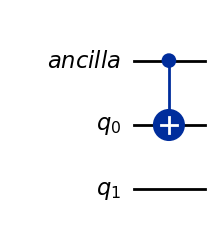

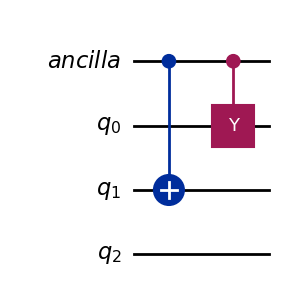

In [128]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli, PauliList
from qiskit.exceptions import QiskitError

def CA(pauli_input):
    """
    Creates a controlled-Pauli circuit using an ancilla qubit as the control.

    Parameters:
        pauli_input (str, Pauli, or PauliList): 
            - A Pauli string (e.g., "IXY").
            - A Qiskit Pauli object (e.g., from SparsePauliOp.paulis[0]).
            - A Qiskit PauliList object, where the first Pauli will be used.
    
    The circuit uses two registers:
        - An ancilla register of size 1 named "ancilla" (the control qubit).
        - A data register of size nqubits named "q" (the target qubits).
    
    For each position in the Pauli operator:
        - 'I': Do nothing.
        - 'X': Apply a controlled-X (CX) gate.
        - 'Z': Apply a controlled-Z (CZ) gate.
        - 'Y': Apply a controlled-Y (CY) gate.
    
    Returns:
        QuantumCircuit: The constructed controlled-Pauli circuit.
    """

    # Convert input to a Pauli object if it is a string
    if isinstance(pauli_input, str):
        try:
            pauli = Pauli(pauli_input)  # Convert string to Pauli object
        except QiskitError:
            raise ValueError(f"Invalid Pauli string '{pauli_input}'. Allowed characters: I, X, Y, Z.")
    
    # If input is already a Pauli object, use it directly
    elif isinstance(pauli_input, Pauli):
        pauli = pauli_input
    
    # If input is a PauliList, extract the first Pauli (document states pauli_list[0] returns Pauli)
    elif isinstance(pauli_input, PauliList):
        if len(pauli_input) == 0:
            raise ValueError("PauliList must contain at least one Pauli operator.")
        pauli = pauli_input[0]  # Extract first Pauli object
    
    # Reject invalid types
    else:
        raise TypeError(f"Expected input type str, Pauli, or PauliList, but received {type(pauli_input)}.")
    
    # Determine the number of qubits
    nqubits = pauli.num_qubits
    
    # Create registers
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    
    # Create circuit
    circ = QuantumCircuit(ancilla, data, name="CA")
    
    # Loop over each Pauli term directly from the Pauli object
    for i, p in enumerate(pauli.to_label()):  # Ensure compatibility with string indexing
        
        # Qiskit follows little Endian convention for qubit ordering. 
        # The most signifcant qubit is the one on the left in hand-written form. 
        # Hence, we need to reverse the index to match qubit numbering.
        i = nqubits - i - 1
        # E.g. nqubits =3, [0,1,2] becomes [2,1,0]
        
        if p == "I":
            continue
        elif p == "X":
            circ.cx(ancilla[0], data[i])
        elif p == "Z":
            circ.cz(ancilla[0], data[i])
        elif p == "Y":
            circ.cy(ancilla[0], data[i])
        else:
            raise ValueError(f"Unsupported Pauli operator: {p}")
    
    return circ
display(CA(LCU.paulis[1]).draw("mpl"))
display(CA("IXY").draw("mpl"))

### Implement $|b\rangle$ with $U |0\rangle$

For simplicity, let use a $|b\rangle$ that is easy to implement. Let
$$|b\rangle = \frac{1}{2} \begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$$

$|b\rangle$ can be prepared by applying a Hadamard gate to each qubit.

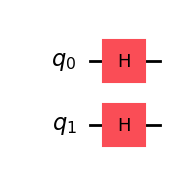

In [110]:
def U_hadamard(nqubits):
    """
    Creates a circuit of size 'nqubits' that represents U_hadamard.
    For our problem, we only need to apply Hadamard on each qubit to prepare |b>.
    
    In general, U_b would be a unitary that maps |0> to |b> (or vice versa).

    Returns:
        circuit (QuantumCircuit): A quantum circuit of size 'nqubits'.
    """
    circ = QuantumCircuit(nqubits, name="U_hadamard")
    # Example placeholder: apply H on each qubit
    for i in range(nqubits):
        circ.h(i)
    return circ

# |b> with two qubits:
display(U_hadamard(2).draw("mpl"))

### Fixed Structure Ansatz for $|x(\alpha)\rangle$
Consider the ansatz $V(\alpha)$, quantum a circuit that prepares a state $|x(\alpha)\rangle$ given a set of parameters, $\alpha$. 

There different techniques for preparing the ansatz, including fixed ansatz, variable ansatz and Quantum Alternating Operator Ansatz (QAOA). 

Here, we use a very basic fixed ansatz.

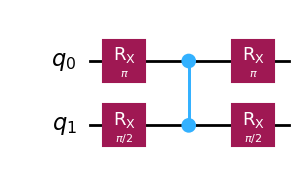

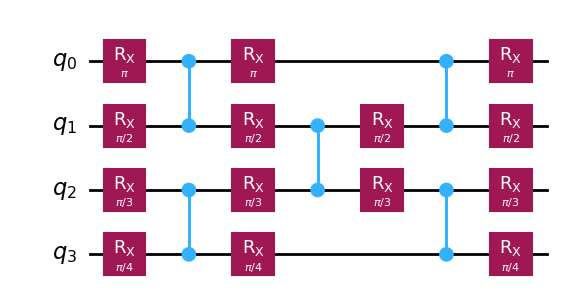

In [120]:

def fixed_ansatz(parameters, nqubits=None):
    """
    Creates a parameterized "ansatz circuit" on 'nqubits' data qubits.
    'parameters' is a list of layers, for example [[θ₀, θ₁, ...], [θ₂, θ₃, ...], ...].
    The number of layers is the circuit depth.
    
    Between each layer (except the last), a CZ entangling layer is inserted.
    The entangling pattern alternates:
    - For even layers (0, 2, ...): apply CZ on pairs (0,1), (2,3), ...
    - For odd layers (1, 3, ...): apply CZ on pairs (1,2), (3,4), ...
    
    In a non-final layer, Ry gates are only applied to qubits that will be entangled in the next CZ layer.
    
    Returns:
        QuantumCircuit: The constructed ansatz circuit.
    """
    num_layers = len(parameters)
    # If nqubits is not specified, determine it from the parameters.
    if nqubits is None:
        nqubits = max(len(parameters[i]) for i in range(num_layers))
    
    # Initialize the ansatz circuit.
    ansatz = QuantumCircuit(nqubits, name="ansatz")
    
    for layer_idx, layer in enumerate(parameters):
        # For non-final layers, determine qubits that will be entangled in the next layer.
        if layer_idx < num_layers - 1:
            if layer_idx % 2 == 0:
                # Even layer: entangle pairs (0,1), (2,3), ...
                entangled = {i for pair in range(0, nqubits - 1, 2) for i in (pair, pair + 1)}
            else:
                # Odd layer: entangle pairs (1,2), (3,4), ...
                entangled = {i for pair in range(1, nqubits - 1, 2) for i in (pair, pair + 1)}
            # Apply Ry only on qubits that will be involved in the next CZ layer.
            for i, theta in enumerate(layer[:nqubits]):
                if i in entangled:
                    ansatz.rx(theta, i)
        else:
            # For the final layer, apply Ry to all qubits.
            for i, theta in enumerate(layer[:nqubits]):
                ansatz.rx(theta, i)
                
        # After each layer (except the final one) insert the alternating CZ entangling layer.
        if layer_idx < num_layers - 1:
            if layer_idx % 2 == 0:
                for i in range(0, nqubits - 1, 2):
                    ansatz.cz(i, i + 1)
            else:
                for i in range(1, nqubits - 1, 2):
                    ansatz.cz(i, i + 1)
                    
    return ansatz

params1 = [[pi/1, pi/2], [pi/1, pi/2]]
params2 = [[pi/1, pi/2, pi/3, pi/4], 
            [pi/1, pi/2, pi/3, pi/4], 
            [pi/1, pi/2, pi/3, pi/4], 
            [pi/1, pi/2, pi/3, pi/4]]

# Display the circuits with modified parameters
display(fixed_ansatz(parameters=params1, nqubits=2).draw("mpl"))
display(fixed_ansatz(params2).draw("mpl"))

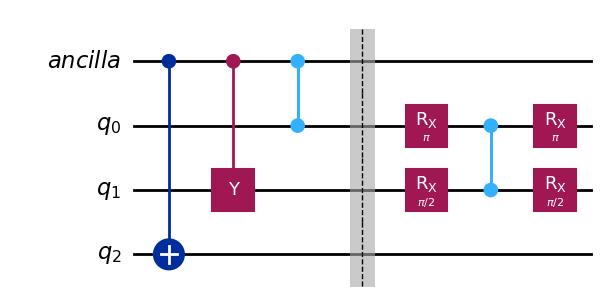

In [150]:
# Testing the function for circuit composition

ancilla = QuantumRegister(1, name="ancilla")
data = QuantumRegister(3, name="q")
test_circ = QuantumCircuit(ancilla, data)

test_circ.compose(CA("XYZ"), inplace=True)
test_circ.barrier()
test_circ.compose(fixed_ansatz(parameters=params1, nqubits=2), qubits=data[0:2], inplace=True)

display(test_circ.draw("mpl"))

Only the parameters change for each run of the circuit. The $Ry$ gates search the state space, while the $CZ$ gates create "interference" between qubits. 

Rx and CZ gates are native to IBM Heron Computers\
 that is why they are chosen.


### Cost Function

Several cost functions are proposed:

1. $C_G$

$$C_G = 1 - | \langle b| \frac{|\psi\rangle}{\|\psi\|} \rangle |^2$$

We project $|\psi\rangle = A |x(\alpha)\rangle$ onto the subspace orthogonal to $|b\rangle$.
$C_G(\alpha)$ equals the norm squared of the projection.

Note that $|\psi\rangle$ is not normalized, so we need to normalize it before computing the projection.

As the number of qubits increases, the gradient of $C_G$ vanishes so we introduce the local cost function.

<br>

2. $C_L$, a local version of $C_G$.

First, let us define

$$P_1 = \left( \mathbb{1} - \frac{1}{n} \sum_{j=1}^{n} |0_j \rangle \langle 0_{j} | \otimes \mathbb{1}_{\bar{j}} \right)$$

where $\mathbb{1}_{\bar{j}}$ is the identity on all qubits except the j-th qubit.

Also,

$$P_0 = \frac{1}{2} + \frac{1}{2n} \sum_{j=1}^{n} Z_j
$$
where $Z_j$ is the Pauli-Z operator on the j-th qubit and identity on every other qubit.

When multipled by a standard-basis vector, $P_0$ counts the number of 0's in the vector, and $P_1$ counts the number of 1's. For example, if $|a \rangle$ has $m$ 1's and $n$ qubits, then $P_1 |a\rangle = \frac{m}{n} |a\rangle$, and $P_0 |a\rangle = \frac{n-m}{n} |a\rangle$.

Notice that

$$P_1 = \mathbb{1} - P_0 $$

Therefore,

$$C_L = \frac{\hat{C}_L} {\| \psi\|^2} = \frac{\langle x | H_L | x \rangle} {\| \psi\|^2}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle - \langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = 1 - \frac{\langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n}\langle x | A^\dagger U Z_j U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n}\langle 0|V^\dagger A^\dagger U Z_j U^\dagger A V|0 \rangle} {\langle 0|V^\dagger A^\dagger A  V|0 \rangle}$$


Since controlled-Z gate is native to IBM Heron processor, we can directly implement $Z_j$ gates to improve efficiency of the algorithm running on IBM Heron processors.

Since

$$A = \sum_{l=1}^{L} c_lA_l$$
where $c_l \in \mathbb{C}$, we can expand $A$ to get:

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$


### Cost Function Circuit

To calculate the cost function, we can use `Hadamard Test` circuit. The paper [5] introduces a new circuit, `Hadamard-Overlap Test`, to compute $C_L$. 

Here, we use a basic `Hadamard Test`. 

![Hadamard test](images\Hadamard_test.webp)

![Image from Pennylane](images\vqls_hadamard_test_circuit.png)

A_l is: IX
A_l' is: XX
j = 0

For the real part:


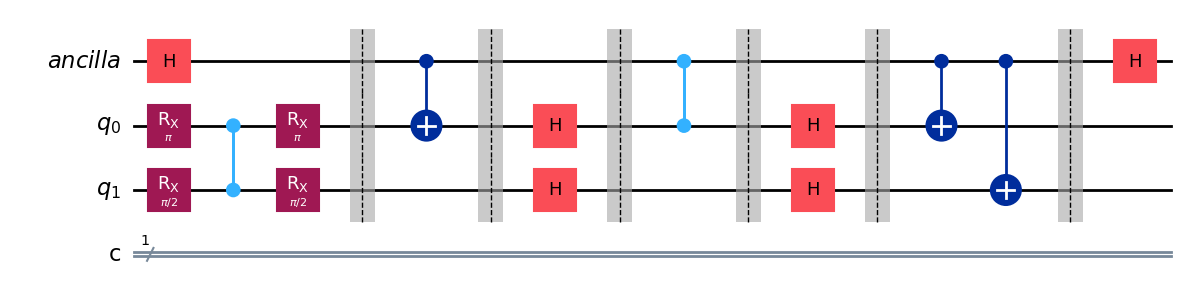

For the imaginary part:


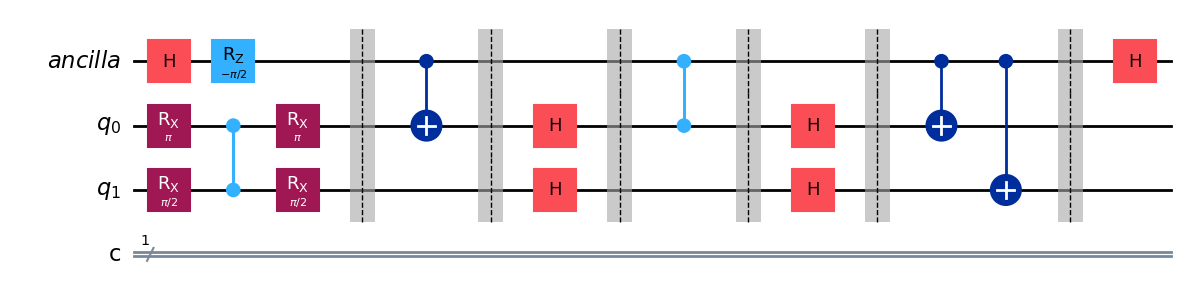

In [165]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def local_hadamard_test(parameters, nqubits, l, j, lp, part="Re"):
    """
    Builds the main circuit for the local Hadamard test as in your diagram.

    Args:
        parameters (list): Parameters for fixed_ansatz, e.g. [[1,1],[1,1]].
        nqubits (int): Number of data qubits (not counting the ancilla).
        l (str): Pauli string for A_l (e.g. "IX").
        j (int): Index of the data qubit for the controlled-Z. If j = -1, skip the CZ.
        lp (str): Pauli string for A_{l'}.
        part (str): "Re" or "Im". If "Im", apply a phase shift Rz(-pi/2) on the ancilla
                    to measure the imaginary part.

    Returns:
        QuantumCircuit: The complete Hadamard test circuit with measurement on the ancilla.
    """
    # 0) Create registers: 1 ancilla + nqubits data + 1 classical bit for measurement
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    cbit = ClassicalRegister(1, name="c")
    
    main_circuit = QuantumCircuit(ancilla, data, cbit, name="LocalHadamardTest")

    # 1) Hadamard on ancilla
    main_circuit.h(ancilla[0])

    # 1.5) (Optional) Phase shift for measuring imaginary part
    if part.lower().strip() in ["im", "imag", "imaginary"]:
        main_circuit.rz(-np.pi / 2, ancilla)

    # 2) Apply the fixed ansatz V(w) to the data qubits
    ansatz_circ = fixed_ansatz(parameters, nqubits)
    # Map data qubits of ansatz onto the 'data' register in main_circuit
    main_circuit.compose(ansatz_circ, qubits=data, inplace=True)
    main_circuit.barrier()
    
    # 3) Controlled A_l
    ca_l = CA(l)  # This subcircuit has 1 ancilla + nqubits data
    # Map the ancilla -> ancilla, data -> data[:]
    main_circuit.compose(
        ca_l,
        # qubits=[ancilla] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 4) U_hadamard^\dagger
    ub_circ = U_hadamard(nqubits)
    main_circuit.compose(
        ub_circ.inverse(),
        qubits=data,  # apply to the data qubits
        inplace=True
    )
    main_circuit.barrier()
    
    # 5) Controlled-Z(ancilla, j) if j != -1
    if j != -1:
        main_circuit.cz(ancilla, data[j])
    main_circuit.barrier()
    
    # 6) U_hadamard
    main_circuit.compose(
        ub_circ,
        qubits=data,
        inplace=True
    )
    main_circuit.barrier()
    
    # 7) Controlled A_{l'}^\dagger
    # First build the subcircuit for A_{l'}, then invert it
    ca_lp = CA(lp)
    ca_lp_inv = ca_lp.inverse()
    main_circuit.compose(
        ca_lp_inv,
        qubits=[ancilla[0]] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 8) Hadamard on ancilla
    main_circuit.h(ancilla)

    # 9) Measure ancilla in classical bit 0
    # main_circuit.measure(ancilla, cbit)

    return main_circuit


print(f"A_l is: {LCU.paulis[1]}")
print(f"A_l' is: {LCU.paulis[2]}")
print("j = 0", end="\n\n")

print("For the real part:")
test_circ = local_hadamard_test(params1, nqubits=2, l=LCU.paulis[1], j=0, lp=LCU.paulis[2], part="Re")
display(test_circ.draw("mpl"))

print("For the imaginary part:")
test_circ2 = local_hadamard_test(params1, nqubits=2, l=LCU.paulis[1], j=0, lp=LCU.paulis[2], part="Im")
display(test_circ2.draw("mpl"))

To get the real (and imaginary) part, one inefficient way is to measure the ancilla qubit. 

Let the probability of measuring $|0\rangle$ is $p_0$ and the probability of measuring $|1\rangle$ is $p_1$. The real part would be $Re = p_0 - p_1$. 

A more efficient way is to use one of the qiskit primitives, `Estimator` or `EstimatorV2` (the other one is `Sampler`). 

In our case, we want to measure the expectation value of Pauli-Z on the ancilla qubit. 

Suppose the ancilla qubit is $|\psi\rangle$, then the expectation value is $\langle \psi | Z | \psi \rangle = p_0 - p_1 = Re$

## 4. Acknowledgements

This implementation is based on the work presented in the research paper [5] by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles.